In [98]:
import sklearn as skl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

from sklearn.base import BaseEstimator, RegressorMixin

In [99]:
class ClusteredRegressor(BaseEstimator, RegressorMixin):
    _parameter_constraints: dict = {}
    
    def __init__(self, *, cluster_algorithm = KMeans(n_clusters=2, n_init=10), strat = np.median):
        self.cluster_algorithm = cluster_algorithm
        self.strat = strat
        self.train_X = None
        self.train_y = None
    
    def fit(self, X, y=None):
        self.train_X = X
        self.train_y = np.array(y)

        return self
    
    def predict(self, X):
        self.cluster_algorithm.fit(np.concatenate((self.train_X, X), axis=0))
        labels = self.cluster_algorithm.labels_
        cluster_medians = {}
        for cluster_label in set(labels):
            cluster_mask = labels == cluster_label
            if (self.train_y is None):
                cluster_medians[cluster_label] = 0
            elif (len(self.train_y[cluster_mask[:len(self.train_y)]]) == 0):
                cluster_medians[cluster_label] = self.strat(self.train_y)
            else:
                cluster_medians[cluster_label] = self.strat(self.train_y[cluster_mask[:len(self.train_y)]])
        y_pred = []
        for x in labels[-len(X):]:
            y_pred.append(cluster_medians[x])
        return y_pred
    
    def score(self, X, y, sample_weight=None):
        if X is None:
            X = np.zeros(shape=(len(y), 1))
        return super().score(X, y, sample_weight)

# Titanic

In [100]:
models = {'Median imputation':DummyRegressor(strategy='median'), 
          'Mean imputation':DummyRegressor(strategy='mean'), 
          'DBSCAN imputation':ClusteredRegressor(cluster_algorithm = DBSCAN(eps=0.5, min_samples=2)),
          'K-Means imputation':ClusteredRegressor(cluster_algorithm = KMeans(n_clusters=15, n_init=10)),
          'Regression imputation':LinearRegression(),}

metrics = {'Negative Mean Squared Error':'neg_mean_squared_error',
           'Negative Median Absolute Error':'neg_median_absolute_error',}

scaler = RobustScaler()

In [101]:
titanic_df = pd.read_csv('input/train.csv').set_index('PassengerId')

train_df = titanic_df.copy()
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
aln = train_df['SibSp'] + train_df['Parch']
train_df['notAlone'] = aln.where(aln < 1, 1)

train_df = pd.get_dummies(train_df, columns=["Pclass", "Embarked", "Sex"], dtype=int)

train_df.drop(['Survived', 'Cabin', 'Sex_female', 'Name', 'Ticket', 'SibSp', 'Parch', 'Pclass_3', 'Embarked_S'], axis=1, inplace=True)


In [102]:
X = train_df[train_df['Age'].notna()].loc[:, train_df.columns != 'Age']
X = DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
y = train_df[train_df['Age'].notna()]['Age']

y.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [103]:
metrics_df = DataFrame()
metrics_df['Metric'] = metrics.keys()
metrics_df.set_index('Metric', inplace=True)
for name, model in models.items():   
    scores = cross_validate(model, X, y, cv=5, scoring=list(metrics.values()))
    lst = list()
    for key, value in metrics.items():     
        score = scores['test_'+value] 
        lst.append(score[(score <= np.percentile(score, 95)) & (score >= np.percentile(score, 5))].mean().round(2))
    metrics_df[name] = lst

metrics_df

,Median imputation,Mean imputation,DBSCAN imputation,K-Means imputation,Regression imputation
Metric,,,,,
Negative Mean Squared Error,-213.01,-213.84,-183.78,-177.7,-169.20
Negative Median Absolute Error,-8.50,-9.18,-7.50,-8.0,-8.45


In [104]:
pred_X = train_df[train_df['Age'].isna()].loc[:, train_df.columns != 'Age']
pred_X = DataFrame(scaler.fit_transform(pred_X), columns=pred_X.columns, index=pred_X.index)

res_df = DataFrame()
res_df['PassengerId'] = pred_X.index
res_df.set_index('PassengerId', inplace=True)

for name, model in models.items():   
    pred_y = model.fit(X, y).predict(pred_X)
    res_df[name] = pred_y


titanic_df['Title'] = titanic_df['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

titanic_df['Title'] = titanic_df['Title'].replace({'Mlle':'Miss', 'Ms':'Miss', 'Mme':'Mrs',})

def is_child(row):
    if (((row['Title'] == 'Miss') & (row['Parch'] > 0)) | (row['Title'] == 'Master') | ((row['Parch'] > 0) & (row['SibSp'] > 1))) & (row['Title'] != 'Mrs'):
        return 1
    else:
        return 0

titanic_df['Expected child'] = titanic_df.apply(is_child, axis=1)

res_df['Title median imputation'] = titanic_df.groupby('Title', group_keys=False)['Age'].apply(lambda x: x.fillna(x.median())).to_frame()['Age'][res_df.index]

res_df = titanic_df.loc[res_df.index].merge(res_df, on='PassengerId').round(2)

res_df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Expected child,Median imputation,Mean imputation,DBSCAN imputation,K-Means imputation,Regression imputation,Title median imputation
PassengerId,,,,,,,,,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.46,NaN,Q,Mr,0,28.0,29.7,31.00,32.0,29.53,30.0
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.00,NaN,S,Mr,0,28.0,29.7,30.50,31.0,33.88,30.0
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.22,NaN,C,Mrs,0,28.0,29.7,15.00,22.0,23.96,35.0
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.22,NaN,C,Mr,0,28.0,29.7,28.75,27.0,26.43,30.0
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.88,NaN,Q,Miss,0,28.0,29.7,18.50,22.0,27.09,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.23,NaN,C,Mr,0,28.0,29.7,28.75,27.0,26.43,30.0
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,Miss,1,28.0,29.7,28.00,30.0,16.69,21.0
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.50,NaN,S,Mr,0,28.0,29.7,26.00,27.0,28.09,30.0


In [105]:
train_df.drop(['notAlone'], axis=1, inplace=True)
train_df['Title'] = titanic_df['Title']
train_df = pd.get_dummies(train_df, columns=['Title'], dtype=int)
train_df['Expected child'] = titanic_df['Expected child']
train_df['SibSp'] = titanic_df['SibSp']
train_df['Parch'] = titanic_df['Parch']
train_df.corr()['Age'].sort_values(key=lambda x: abs(x))

Pclass_2              0.006954
Title_the Countess    0.008516
Title_Jonkheer        0.021415
Embarked_Q           -0.022405
Title_Don             0.026575
Embarked_C            0.036261
Title_Lady            0.047214
Title_Sir             0.049794
Title_Major           0.068643
Title_Dr              0.078008
Title_Rev             0.085407
Sex_male              0.093254
Fare                  0.096067
Title_Col             0.103328
Title_Capt            0.103971
Title_Mrs             0.178069
Parch                -0.189119
Title_Mr              0.206341
Title_Miss           -0.277827
SibSp                -0.308247
Pclass_1              0.348941
Title_Master         -0.398827
Expected child       -0.550922
Age                   1.000000
Name: Age, dtype: float64

[ True  True  True  True  True  True  True  True  True False  True  True
  True  True  True  True  True  True  True  True  True  True  True]


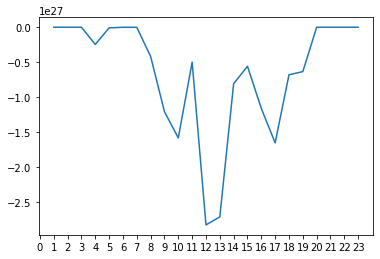

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Expected child,Median imputation,Mean imputation,DBSCAN imputation,K-Means imputation,Regression imputation,Title median imputation,New Regression imputation
PassengerId,,,,,,,,,,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.46,NaN,Q,Mr,0,28.0,29.7,31.00,32.0,29.53,30.0,32.21
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.00,NaN,S,Mr,0,28.0,29.7,30.50,31.0,33.88,30.0,33.02
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.22,NaN,C,Mrs,0,28.0,29.7,15.00,22.0,23.96,35.0,27.19
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.22,NaN,C,Mr,0,28.0,29.7,28.75,27.0,26.43,30.0,26.54
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.88,NaN,Q,Miss,0,28.0,29.7,18.50,22.0,27.09,21.0,26.21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.23,NaN,C,Mr,0,28.0,29.7,28.75,27.0,26.43,30.0,26.54
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S,Miss,1,28.0,29.7,28.00,30.0,16.69,21.0,4.39
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.50,NaN,S,Mr,0,28.0,29.7,26.00,27.0,28.09,30.0,29.04


In [106]:
X = train_df[train_df['Age'].notna()].loc[:, train_df.columns != 'Age']
X = DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
y = train_df[train_df['Age'].notna()]['Age']

rfecv = RFECV(estimator=models['Regression imputation'], step=1, cv=5, scoring='neg_mean_squared_error')
rfecv.fit(X, y)
print(rfecv.support_)
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), rfecv.cv_results_['mean_test_score'])
plt.xticks(np.arange(0, len(rfecv.cv_results_['mean_test_score'])+ 1, 1))
plt.show()
X = X.loc[:, rfecv.support_]

pred_X = train_df[train_df['Age'].isna()].loc[:, train_df.columns != 'Age']
pred_X = DataFrame(scaler.fit_transform(pred_X), columns=pred_X.columns, index=pred_X.index)
pred_X = pred_X.loc[:, rfecv.support_]

pred_y = models['Regression imputation'].fit(X, y).predict(pred_X)
res_df['New Regression imputation'] = np.abs(pred_y.round(2))

res_df.to_csv('output/Titanic Age Imputation Results.csv', decimal=',', sep=';')
res_df

In [107]:
metrics_df = DataFrame()
metrics_df['Metric'] = metrics.keys()
metrics_df.set_index('Metric', inplace=True)
for name, model in models.items():   
    scores = cross_validate(model, X, y, cv=5, scoring=list(metrics.values()))
    lst = list()
    for key, value in metrics.items():     
        score = scores['test_'+value] 
        lst.append(score[(score <= np.percentile(score, 95)) & (score >= np.percentile(score, 5))].mean().round(2))
    metrics_df[name] = lst

metrics_df  

,Median imputation,Mean imputation,DBSCAN imputation,K-Means imputation,Regression imputation
Metric,,,,,
Negative Mean Squared Error,-213.01,-213.84,-175.70,-137.50,-114.82
Negative Median Absolute Error,-8.50,-9.18,-7.56,-6.83,-6.81


# Pima Indians Diabetes

In [108]:
models = {'Median imputation':DummyRegressor(strategy='median'), 
          'Mean imputation':DummyRegressor(strategy='mean'), 
          'DBSCAN imputation':ClusteredRegressor(cluster_algorithm = DBSCAN(eps=0.5, min_samples=2)),
          'K-Means imputation':ClusteredRegressor(cluster_algorithm = KMeans(n_clusters=15, n_init=10)),
          'Regression imputation':LinearRegression(),}

metrics = {'Negative Mean Squared Error':'neg_mean_squared_error',
           'Negative Median Absolute Error':'neg_median_absolute_error',}

scaler = RobustScaler()

In [109]:
diabetes_df = pd.read_csv('input/diabetes.csv')
train_df = diabetes_df.copy()
train_df["Glucose"] = train_df["Glucose"].apply(lambda x: np.nan if x == 0 else x)
train_df["BloodPressure"] = train_df["BloodPressure"].apply(lambda x: np.nan if x == 0 else x)
train_df["SkinThickness"] = train_df["SkinThickness"].apply(lambda x: np.nan if x == 0 else x)
train_df["Insulin"] = train_df["Insulin"].apply(lambda x: np.nan if x == 0 else x)
train_df["BMI"] = train_df["BMI"].apply(lambda x: np.nan if x == 0 else x)
train_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [110]:
train_df.isna().sum().apply(lambda x: f'{(x / train_df.shape[0] * 100):.2f}%')


Pregnancies                  0.00%
Glucose                      0.65%
BloodPressure                4.56%
SkinThickness               29.56%
Insulin                     48.70%
BMI                          1.43%
DiabetesPedigreeFunction     0.00%
Age                          0.00%
Outcome                      0.00%
dtype: object

In [111]:
train_df.corr()['Outcome'].sort_values(key=lambda x: abs(x))

BloodPressure               0.170589
DiabetesPedigreeFunction    0.173844
Pregnancies                 0.221898
Age                         0.238356
SkinThickness               0.259491
Insulin                     0.303454
BMI                         0.313680
Glucose                     0.494650
Outcome                     1.000000
Name: Outcome, dtype: float64

In [112]:
train_df['BloodPressure'] = train_df['BloodPressure'].fillna(train_df['BloodPressure'].mode()[0])
train_df['BMI'] = train_df['BMI'].fillna(train_df['BMI'].mode()[0])
train_df['Glucose'] = train_df['Glucose'].fillna(train_df['Glucose'].mode()[0])
train_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.0,NaN,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.0,26.2,0.245,30,0
766,1,126.0,60.0,NaN,NaN,30.1,0.349,47,1


In [113]:
X1 = train_df[train_df['SkinThickness'].notna()].drop(['SkinThickness', 'Outcome', 'Insulin'], axis=1, inplace=False)
X1 = DataFrame(scaler.fit_transform(X1), columns=X1.columns, index=X1.index)
y1 = train_df[train_df['SkinThickness'].notna()]['SkinThickness']
metrics_df = DataFrame()
metrics_df['Metric'] = metrics.keys()
metrics_df.set_index('Metric', inplace=True)
for name, model in models.items():   
    scores = cross_validate(model, X1, y1, cv=5, scoring=list(metrics.values()))
    lst = list()
    for key, value in metrics.items():     
        score = scores['test_'+value] 
        lst.append(score[(score <= np.percentile(score, 95)) & (score >= np.percentile(score, 5))].mean().round(2))
    metrics_df[name] = lst

metrics_df

,Median imputation,Mean imputation,DBSCAN imputation,K-Means imputation,Regression imputation
Metric,,,,,
Negative Mean Squared Error,-106.74,-107.14,-98.75,-74.71,-58.78
Negative Median Absolute Error,-7.62,-7.33,-7.00,-5.19,-5.18


In [114]:
pred_X = train_df[train_df['SkinThickness'].isna()].drop(['SkinThickness', 'Outcome', 'Insulin'], axis=1, inplace=False)
pred_X = DataFrame(scaler.fit_transform(pred_X), columns=pred_X.columns, index=pred_X.index)
pred_X['SkinThickness'] = models['Regression imputation'].fit(X1, y1).predict(pred_X)
train_df.loc[train_df['SkinThickness'].isna(), 'SkinThickness'] = pred_X['SkinThickness'].round(2)
train_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.00,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.00,NaN,26.6,0.351,31,0
2,8,183.0,64.0,22.28,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.00,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.00,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.00,180.0,32.9,0.171,63,0
764,2,122.0,70.0,27.00,NaN,36.8,0.340,27,0
765,5,121.0,72.0,23.00,112.0,26.2,0.245,30,0
766,1,126.0,60.0,28.52,NaN,30.1,0.349,47,1


In [115]:
X2 = train_df[train_df['Insulin'].notna()].drop(['Outcome', 'Insulin'], axis=1, inplace=False)
X2 = DataFrame(scaler.fit_transform(X2), columns=X2.columns, index=X2.index)
y2 = train_df[train_df['Insulin'].notna()]['Insulin']
metrics_df = DataFrame()
metrics_df['Metric'] = metrics.keys()
metrics_df.set_index('Metric', inplace=True)
for name, model in models.items():   
    scores = cross_validate(model, X2, y2, cv=5, scoring=list(metrics.values()))
    lst = list()
    for key, value in metrics.items():     
        score = scores['test_'+value] 
        lst.append(score[(score <= np.percentile(score, 95)) & (score >= np.percentile(score, 5))].mean().round(2))
    metrics_df[name] = lst

metrics_df

,Median imputation,Mean imputation,DBSCAN imputation,K-Means imputation,Regression imputation
Metric,,,,,
Negative Mean Squared Error,-14341.0,-13416.70,-14154.38,-11770.17,-9506.38
Negative Median Absolute Error,-54.0,-66.39,-53.83,-43.50,-45.90


In [116]:
pred_X = train_df[train_df['Insulin'].isna()].drop(['Outcome', 'Insulin'], axis=1, inplace=False)
pred_X = DataFrame(scaler.fit_transform(pred_X), columns=pred_X.columns, index=pred_X.index)
pred_X['Insulin'] = models['Regression imputation'].fit(X2, y2).predict(pred_X)
train_df.loc[train_df['Insulin'].isna(), 'Insulin'] = pred_X['Insulin'].round(2)
train_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.00,244.09,33.6,0.627,50,1
1,1,85.0,66.0,29.00,74.58,26.6,0.351,31,0
2,8,183.0,64.0,22.28,298.42,23.3,0.672,32,1
3,1,89.0,66.0,23.00,94.00,28.1,0.167,21,0
4,0,137.0,40.0,35.00,168.00,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.00,180.00,32.9,0.171,63,0
764,2,122.0,70.0,27.00,177.02,36.8,0.340,27,0
765,5,121.0,72.0,23.00,112.00,26.2,0.245,30,0
766,1,126.0,60.0,28.52,197.23,30.1,0.349,47,1


In [117]:
X = train_df.drop('Outcome', axis=1, inplace=False)
X = DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
y = train_df['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [118]:
log_params = {'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10, 100]} 
log_model = GridSearchCV(LogisticRegression(max_iter=300, solver='liblinear'), log_params, cv=5)
log_model.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=300, solver='liblinear'),
             param_grid={'C': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1, 10,
                               100]})

In [119]:
rf_params = {'criterion' : ['gini', 'entropy'],
             'n_estimators': list(range(60, 140, 20)),
             'max_depth': list(range(3, 20, 2))}
rf_model = GridSearchCV(RandomForestClassifier(), rf_params, cv=5)
rf_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_estimators': [60, 80, 100, 120]})

In [120]:
knn_params = {'n_neighbors': list(range(1,50))}
knn_model = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5)
knn_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]})

In [128]:
classificationModels = {'Logistic Regression':log_model, 
          'Random Forest Classifier':rf_model, 
          'k-NN Classifier':knn_model,}

classificationMetrics = {'Accuracy': accuracy_score,
           'ROC-AUC':roc_auc_score,}

In [129]:
metrics_df = DataFrame()
metrics_df['Metric'] = classificationMetrics.keys()
metrics_df.set_index('Metric', inplace=True)
for name, model in classificationModels.items():   
    lst = list()
    for key, value in classificationMetrics.items():
        lst.append(value(model.predict(X_test), y_test))
    metrics_df[name] = lst

metrics_df

,Logistic Regression,Random Forest Classifier,k-NN Classifier
Metric,,,
Accuracy,0.753247,0.766234,0.740260
ROC-AUC,0.731818,0.750000,0.717262
